### Avito on Demand

Avito, Russia’s largest classified advertisements website, is hosting its fourth Kaggle competition. The challenge is to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts.

About the Data:


train.csv - Train data.
test.csv - Test data. Same schema as the train data, minus deal_probability.
train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.
test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.
periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.
train_jpg.zip - Images from the ads in train.csv.
test_jpg.zip - Images from the ads in test.csv.
sample_submission.csv - A sample submission in the correct format.



In [1]:
#libs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
## Importacao dos dados

In [5]:
train_df = pd.read_csv("avito-demand-prediction//train.csv", parse_dates=["activation_date"], nrows=1000)
test_df = pd.read_csv("avito-demand-prediction//test.csv", parse_dates=["activation_date"], nrows=200)

In [6]:
print("Train : ", train_df.shape)
print("Test: ", test_df.shape)

Train :  (1000, 18)
Test:  (200, 17)


In [7]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [8]:
test_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


### Data Description

The train dataset description is as follows:

    item_id - Ad id.
    user_id - User id.
    region - Ad region.
    city - Ad city.
    parent_category_name - Top level ad category as classified by Avito's ad model.
    category_name - Fine grain ad category as classified by Avito's ad model.
    param_1 - Optional parameter from Avito's ad model.
    param_2 - Optional parameter from Avito's ad model.
    param_3 - Optional parameter from Avito's ad model.
    title - Ad title.
    description - Ad description.
    price - Ad price.
    item_seq_number - Ad sequential number for user.
    activation_date- Date ad was placed.
    user_type - User type.
    image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
    image_top_1 - Avito's classification code for the image.
    deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.
    
    So deal probability is the target variable, vaires between 0 and 1.


<Figure size 864x576 with 0 Axes>

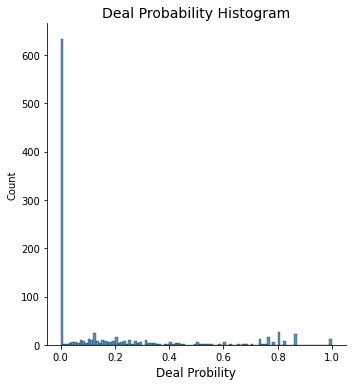

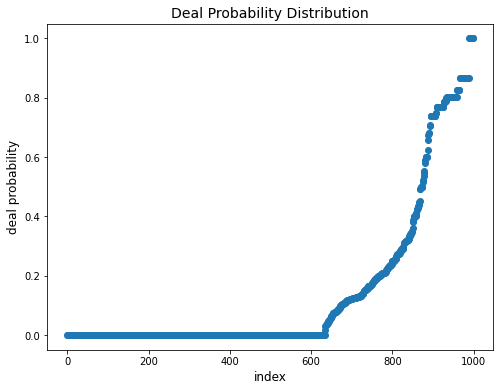

In [10]:
plt.figure(figsize=(12,8))
sns.displot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

## So almost 600 Ads has 0 probaility (which means it did not sell anything) and few ads have a probability of 1. Rest of the deal probabilities have values in between.

In [12]:
from io import StringIO

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, region_df, how="left", on="region")

In [13]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,region_en
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,Sverdlovsk oblast
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000,Samara oblast
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177,Rostov oblast
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323,Tatarstan
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797,Volgograd oblast


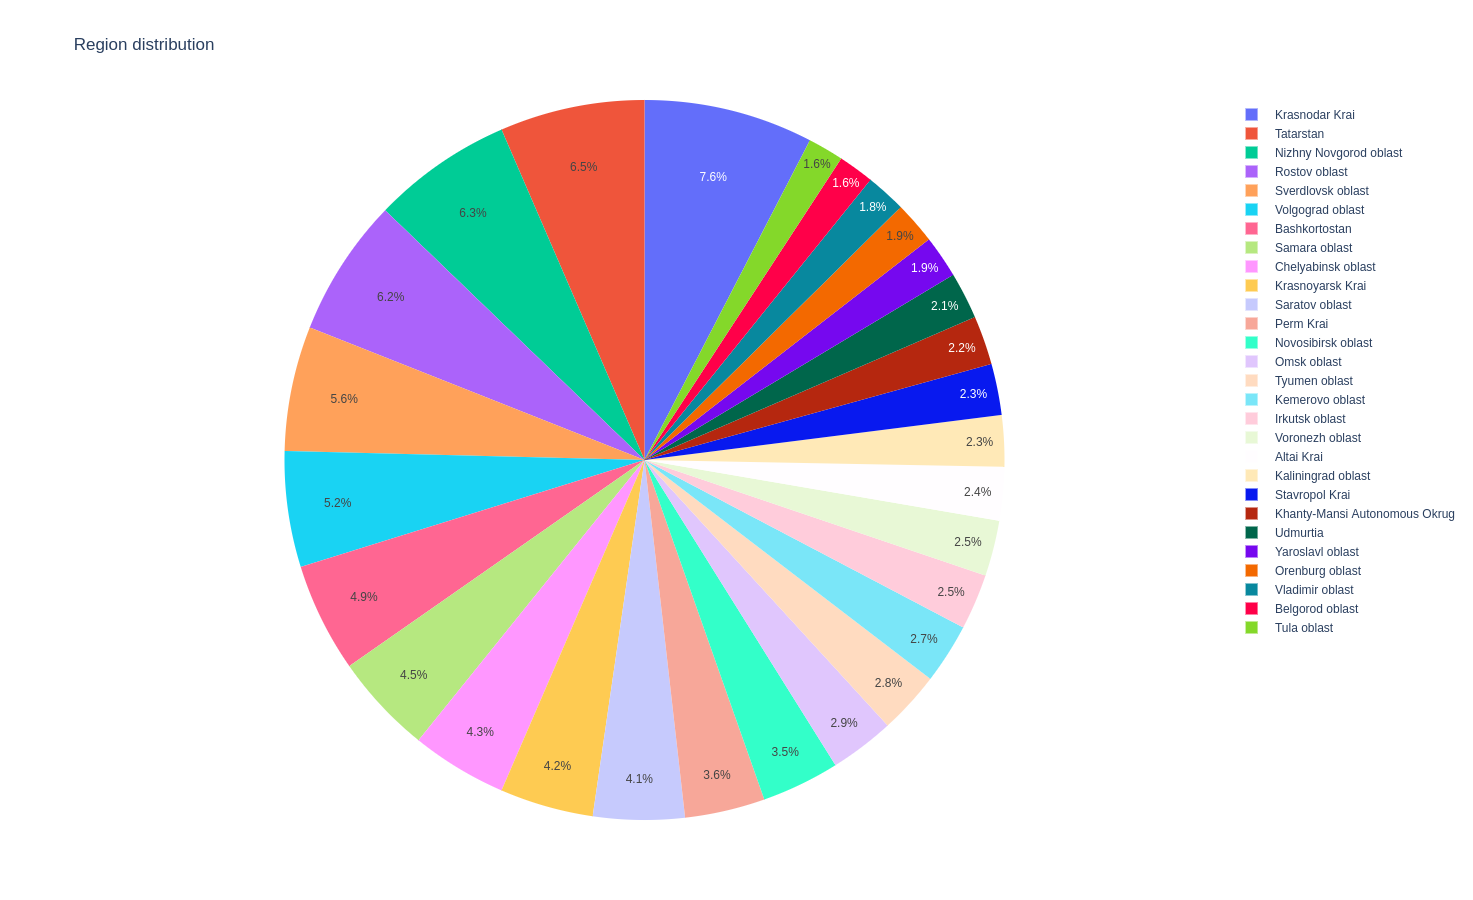

In [14]:
temp_series = train_df['region_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

The regions have percentage of ads between 1.71% to 9.41%. So the top regions are:

    Krasnodar region - 9.41%
    Sverdlovsk region - 6.28%
    Rostov region - 5.99%

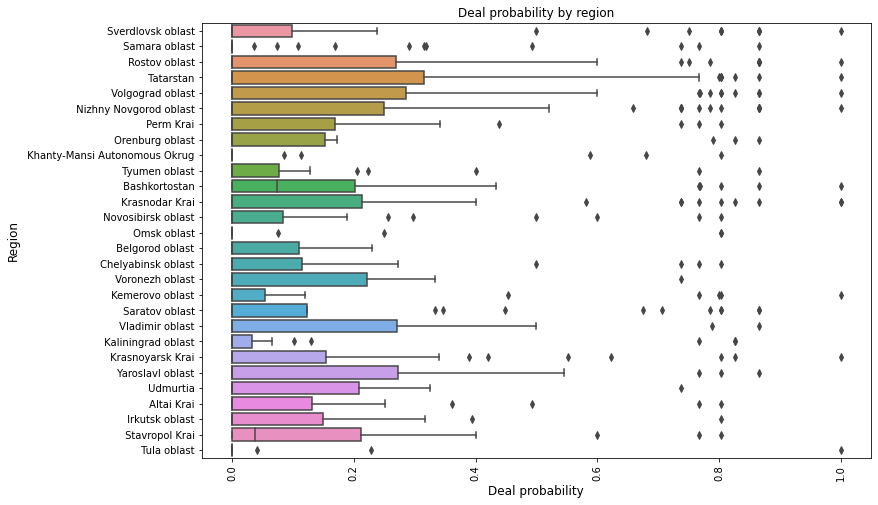

In [15]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

Top 20 cities:


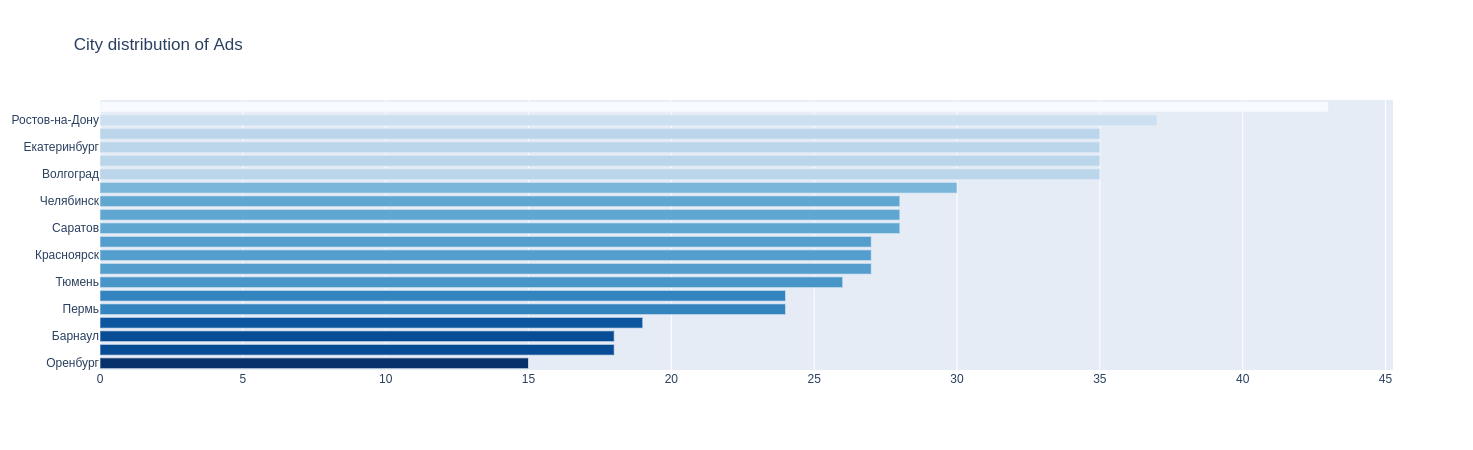

In [16]:
print('Top 20 cities:')

cnt_srs = train_df['city'].value_counts().head(20)
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='City distribution of Ads',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CityAds")

In [17]:
temp_data = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")

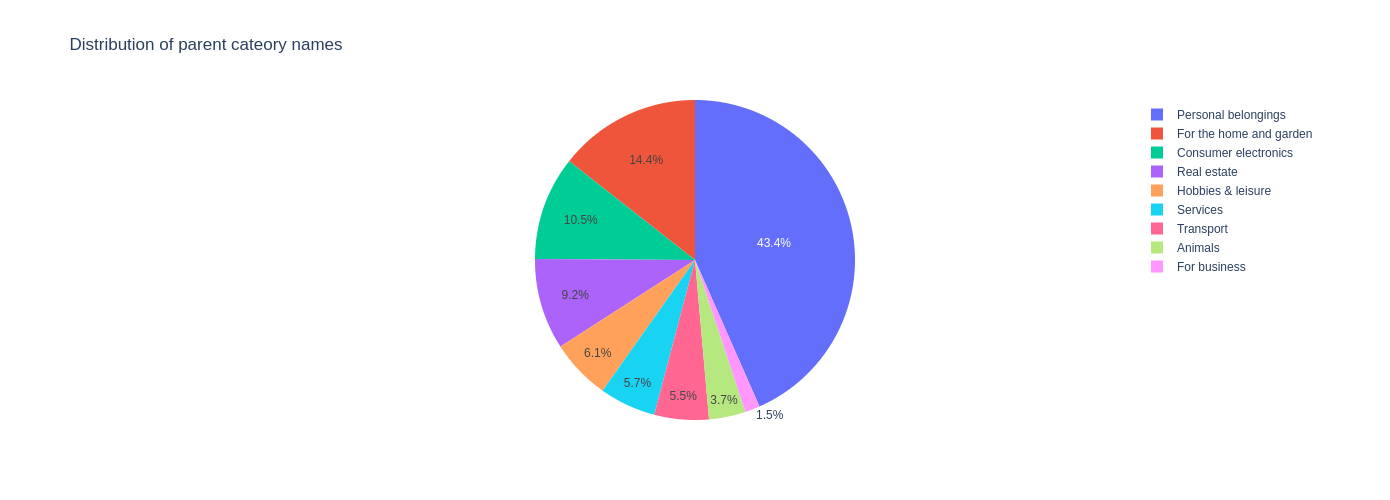

In [20]:


temp_series = train_df['parent_category_name_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title=' Distribution of parent cateory names',
    width=500,
    height=500,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="parentcategory")

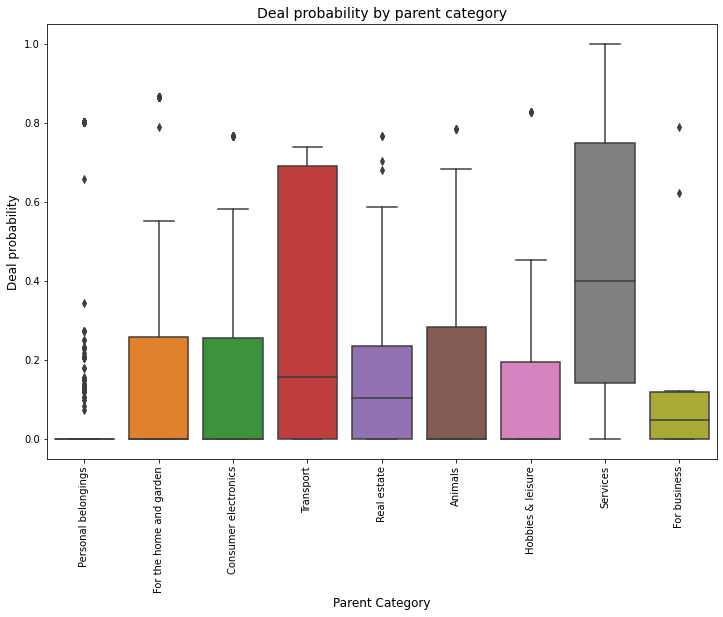

In [21]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name_en", y="deal_probability", data=train_df)
plt.ylabel('Deal probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()